# FIFA Market Value Prediction

The goal of this project is to predict the market value of footballplayers from the game FIFA based on their attributes.

In [1]:
#In order to execute this, make sure you have installed xgboost, lightgbm and bayes_opt

# Basic data transformations/preprocessing and visualization
import pandas as pd
import numpy as np
from math import sqrt
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
import warnings
warnings.filterwarnings('ignore')

# Splitting, Evaluation
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.metrics import mean_squared_error, make_scorer, r2_score

# Models
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn import tree

import xgboost as xgb 
import lightgbm as lgb

# Optimization
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline

In [2]:
# Load data
df = pd.read_csv("utils/fifa_data_without_duplicates")

# Preprocessing

## Cleaning

In [3]:
# Converts to the correct the input value to the correct number (eg. 10k --> 10,000, 1M --> 1,000,000)
def convert_to_number(value):
    value = value[1:]
    if value[-1] == "K":
        return float(value.replace("K", "")) * 1000
    elif value[-1] == "M":
        return float(value.replace("M", "")) * 1000000
    else:
        return float(value)  

In [4]:
# Data Cleaning --> Remove unnecessary characters
df['market_value'] = df['market_value'].apply(convert_to_number)
df["height"] = df["height"].str[:-2].astype(np.int64)
df["weight"] = df["weight"].str[:-2].astype(np.int64)
df["weak_foot"] = df["week_foot"].str[0].astype(int)
df["skill_moves"] = df["skill_moves"].str[0].astype(int)

# Delete players that have market value of zero
df.drop(df[df['market_value'] == 0].index, inplace = True, axis = 0)

print(f'Number of teams: {len(df["team"].unique())}')

# Delete unnecassary columns; "week_foot" deleted since we have weak_foot now spelled correctly
df_names = df[["id", "name"]]
df.drop(["joined", "name", "week_foot", "team"], axis = 1, inplace = True)

Number of teams: 925


## Feature Engineering

In [5]:
# Indicate loan players
df["loan_player"] = np.where(df["contract_duration"].str.contains("loan", case = False), 1, 0)

# Get contract_end and drop players which have contract end older than 2020 (so called icons in fifa)
df["contract_end"] = df["contract_duration"].str[8:]
df["contract_end"] = df["contract_end"].str.extract('(\d+)').astype(np.float64)

#players with contract end before 2020 are dropped
print(f"Number of players with contract end before 2020: {len(df[df['contract_end'] < 2020])}")
df.drop(df[df['contract_end'] < 2020].index, inplace = True)

# Get contract start, for loan players this data is missing. For now we set the contract start of loan players to missing
df["contract_start"] = np.where(df["loan_player"] == True, np.nan, df["contract_duration"].str[0:6]).astype(np.float64)

# compute contract duration from 2021 onwards
df["contract_duration"] = df["contract_end"] - 2021

Number of players with contract end before 2020: 925


In [6]:
df.isnull().sum().sort_values(ascending=False).head(5)
# These are missing contract_starts for loan players: Impute missing data by the median of the players with same contract end
df["contract_start"] = df[["contract_end", "contract_start"]].groupby("contract_end").transform(lambda x: x.fillna(x.median()))

## Encodings

In [7]:
# Binary encoding for preferred_foot
df["preferred_foot"] = df["preferred_foot"].apply(lambda x: 0 if x == 'Left' else 1)

# One-hot-encode best_position feature
one_hot_encoder = OneHotEncoder()

df.reset_index(inplace = True, drop = True)
encoded = pd.DataFrame(one_hot_encoder.fit_transform(df[["best_postion"]]).toarray(), 
                       columns=one_hot_encoder.get_feature_names(["best_postion"]))

df.drop(columns=["best_postion"], inplace = True)
df = df.join(encoded)

## Outlier Deletion
We check here for outliers simply by using the z_score. After analysing the table with outliers we can see that there are only "natural" outliers and thus no outliers which occur by mistakes. We decide to keep the outliers so our data is not just a simplification of the real world. Furthermore there is also information inoutliers.
Although we create a separate filtered DataFrame here, we continue with the unfiltered one due to the reasons outlined before.

In [8]:
pd.set_option('display.max_rows', 50)
# Calculate z_score
z_scores = stats.zscore(df)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 10).all(axis=1)


z_10 = (abs_z_scores > 10).sum()
z_9 = (abs_z_scores > 9).sum()
z_8 = (abs_z_scores > 8).sum()

print(f"Z = 10: {z_10} samples, Z = 9: {z_9} samples, Z = 8: {z_8} samples")

# Get new dataframe without outliers
new_df = df[filtered_entries]

# Get table with only outliers inside and check them by hand
outliers = df[~df["id"].isin(new_df["id"])].merge(df_names, on = "id")


# delete id since we do not need anymore
df.drop("id", axis = 1, inplace = True)

Z = 10: 108 samples, Z = 9: 315 samples, Z = 8: 328 samples


In [9]:
outliers

,age,overall_rating,height,weight,potential,preferred_foot,best_overall,market_value,attacking,contract_duration,...,best_postion_LB,best_postion_LM,best_postion_LW,best_postion_LWB,best_postion_RB,best_postion_RM,best_postion_RW,best_postion_RWB,best_postion_ST,name
0,23,84,175,70,91,1,86,84500000.0,363,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,F. Chiesa
1,29,89,175,71,89,0,89,101000000.0,394,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,M. Salah
2,20,88,194,94,94,0,90,143500000.0,380,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,E. Haaland
3,22,91,182,73,95,1,92,194000000.0,411,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,K. Mbappé
4,22,84,189,82,92,0,86,94500000.0,395,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,K. Havertz
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,28,64,183,75,64,1,64,600000.0,292,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21 I. Pešić
104,24,66,179,74,66,1,68,975000.0,279,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21 Lucas Medeirão
105,28,67,179,75,67,1,68,1000000.0,303,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Olaetxea
106,28,68,186,75,68,1,68,1200000.0,335,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,D. Thomalla


## Train Test Split

We decide for a test set size of 20% because we will use 10-Fold Cross Validation on the training set throughout this notebook.

In [10]:
# Defining dependent and independent variables
target = df["market_value"]

# Drop dependent variable from X
features = df.drop(["market_value"], axis = 1)

# Train test split
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2,random_state=42, shuffle = True)

## Feature Scaling

In [11]:
# Initialize Scaler
features_no_scale = list(encoded.columns) + ["preferred_foot"]
features_to_scale = [feature for feature in list(x_train.columns) if feature not in features_no_scale]
scaler = StandardScaler()

# fit and transform scaler on x_train and x_test
x_train[features_to_scale] = scaler.fit_transform(x_train[features_to_scale])
x_test[features_to_scale] = scaler.transform(x_test[features_to_scale])

# Model Training and evaluation

## Baseline - Regression Tree (Symbolic Approach)

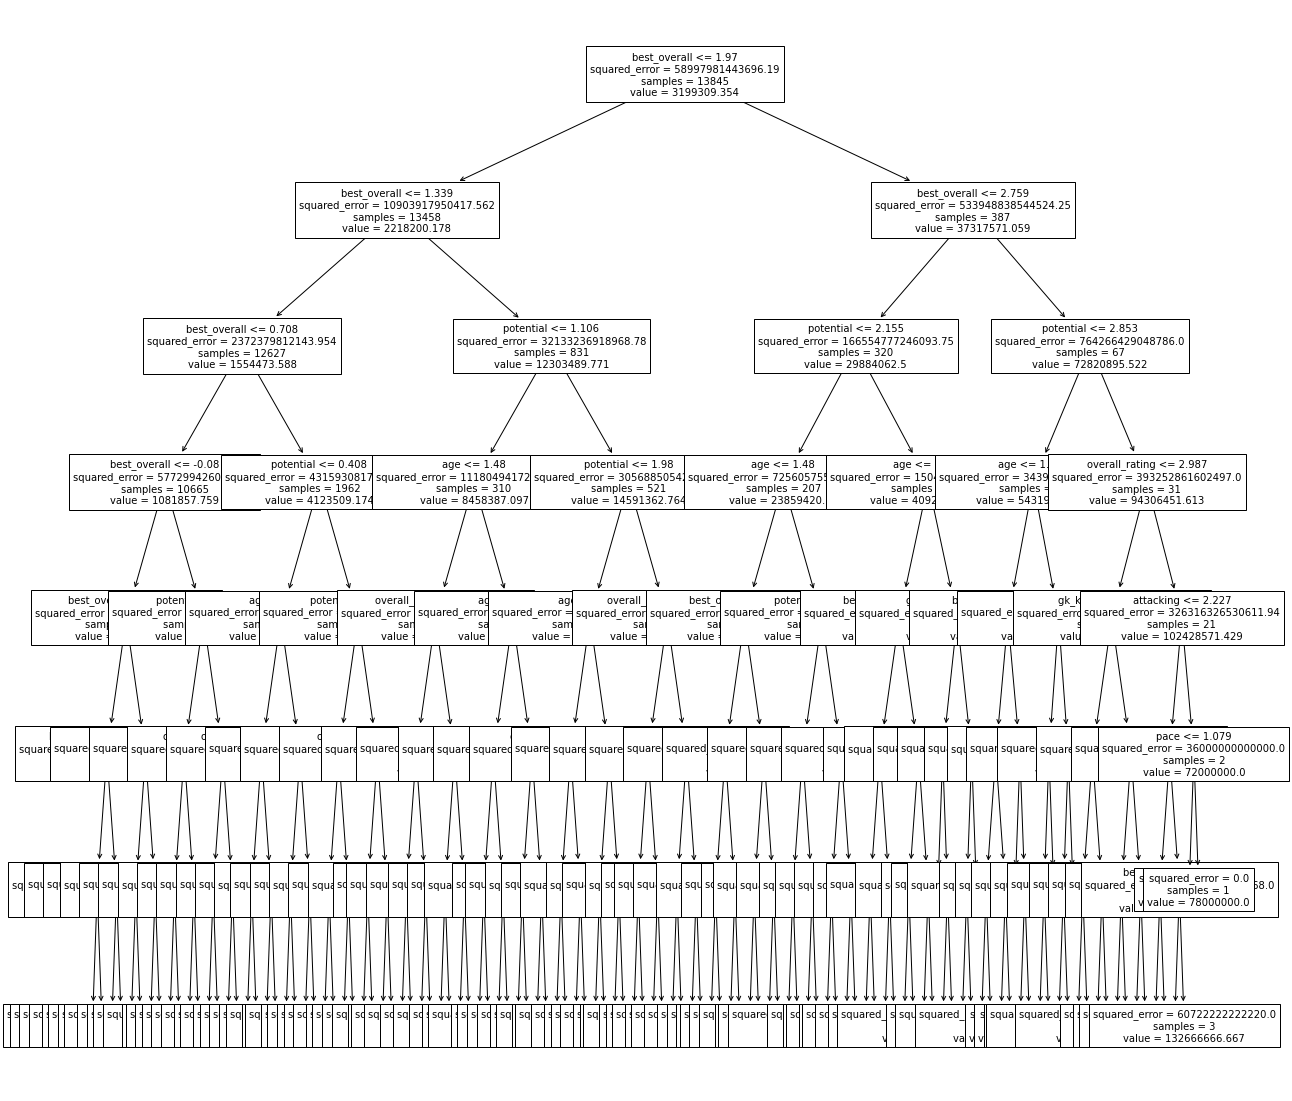

In [21]:
dt_reg = tree.DecisionTreeRegressor(max_depth=20, random_state = 42)
model = dt_reg.fit(x_train, y_train)

#we only plot a tree with max_depth of 5 because otherwise it gets very unreadable. However the tree with max_depth = 20 is used as baseline
dt_reg_vis = tree.DecisionTreeRegressor(max_depth=5, random_state = 42)
dt_reg_vis_model = dt_reg_vis.fit(x_train, y_train)
plt.figure(figsize=(20, 20))
tree.plot_tree(dt_reg_vis_model, fontsize=10, feature_names = list(x_train.columns))
plt.show()

In [27]:
print("Baseline training RMSE (mean):")

mse = make_scorer(mean_squared_error, greater_is_better=False)
train_score = cross_val_score(dt_reg, x_train, y_train, scoring = mse, cv = 10)
print(np.sqrt(-train_score.mean()))


rt_predictions = model.predict(x_test)

# Evaluation based on rmse and r2
rmse = sqrt(mean_squared_error(y_test, rt_predictions))
r2 = r2_score(y_test, rt_predictions)
adj_r2 = 1-(1-r2)*((len(x_test)-1)/(len(x_test)- x_test.shape[1]-1))

print("Baseline test scores:")
print('RMSE:', rmse)
print('ADJ_R2:', adj_r2)

Baseline training RMSE (mean):
1816820.5347880172
Baseline test scores:
RMSE: 2578211.1052387357
ADJ_R2: 0.9204923264902201


## Model Selection with basic optimization

In [17]:
def model_selection(models, features, target):
    model_performances = pd.DataFrame()
    best_model_params = {}
    mse = make_scorer(mean_squared_error, greater_is_better=False)
    for model in models.items():
        model_name = model[0]
        regressor = model[1][0]
        param_grid = model[1][1]
        
        # Find suitable parameters in order to compare the models with their appropriate hyperparameters
        model = GridSearchCV(
            estimator = regressor,
            param_grid = param_grid,
            scoring = mse,
            verbose = 0,
            cv = 10,
            n_jobs = -1
        )
        
        model.fit(features, target)
        
        best_model_params[model_name] = model.best_params_
        
        rmse = sqrt(abs(model.best_score_))
        model_performances[model_name] = [rmse]
        
    model_performances.index = ["RMSE"]
    return model_performances, best_model_params

In [19]:
# Linear Regression
lr_reg = LinearRegression()
lr_params = {}

# Polynominal Regression
pol_reg = Pipeline(
    [
        ("rfe", RFE(LinearRegression())),
        ("transformer", PolynomialFeatures()),
        ("estimator", LinearRegression())
    ]
)

pol_params = {
    "transformer__degree": [2,3],
    "rfe__n_features_to_select": [5,10,11,14,15,20,25]
}

# Ridge Regression
ridge_reg = Ridge() #l2
ridge_params = {"alpha": [0.1, 1.0, 5.0, 10.0]}

# Lasso Regression
lasso_reg = Lasso() #l1
lasso_params = {"alpha": [0.1, 1.0, 5.0, 10.0]}

# Neural Network
clf_reg = MLPRegressor(verbose=False, random_state=42)
clf_params = {
    "hidden_layer_sizes": [(26), (35), (78), (40,38), (40,20,18), (200,100), (100,50), (100,80,40), (100,80,50,30), (100, 80, 50, 30, 20, 10), (300, 200, 100, 80, 50, 30, 10), (200, 100, 80, 50, 30, 10)],
    "activation": ["relu", "tanh"]
}

# Random Forrest Regressor
rf_reg = RandomForestRegressor(random_state=42)
rf_params = {
    'max_depth': [5, 15, 25],
    'max_features': ['auto', 'sqrt'],
    'n_estimators': [70,100,130],
    'min_samples_split': [2, 5, 10]
}

    
# Xg-boost
xgb_reg = xgb.XGBRegressor(random_state=42)
xgb_params = {
    'max_depth': [5, 10, 15],
    'min_child_weight': [15, 50, 100],
    "n_estimators": [15, 50, 100],
    "learning_rate": [0.1, 0.3, 0.4]
}

models = {
     #"lr_reg": (lr_reg, lr_params), 
     #"pol_reg": (pol_reg, pol_params), 
     #"ridge_reg": (ridge_reg, ridge_params),
     #"lasso_reg": (lasso_reg, lasso_params),
     "clf_reg": (clf_reg, clf_params),
     #"rf_reg": (rf_reg, rf_params), 
     #"xgb_reg": (xgb_reg, xgb_params)
}


# Run model_selection
model_performances, model_params = model_selection(models, x_train, y_train)

	lr_reg	pol_reg	ridge_reg	lasso_reg	clf_reg	rf_reg	xgb_reg
RMSE	5.876260e+06	3.526496e+06	5.867234e+06	5.867343e+06	1.256928e+06	1.262610e+06	1.072869e+06

In [20]:
model_performances

,clf_reg
RMSE,1.704228e+06


In [ ]:
RMSE	2.350650e+06

In [16]:
model_params

{'lr_reg': {},
 'pol_reg': {'rfe__n_features_to_select': 25, 'transformer__degree': 2},
 'ridge_reg': {'alpha': 1.0},
 'lasso_reg': {'alpha': 10.0},
 'clf_reg': {'activation': 'relu',
  'hidden_layer_sizes': (100, 80, 50, 30, 20, 10)},
 'rf_reg': {'max_depth': 25,
  'max_features': 'auto',
  'min_samples_split': 2,
  'n_estimators': 130},
 'xgb_reg': {'learning_rate': 0.1,
  'max_depth': 15,
  'min_child_weight': 15,
  'n_estimators': 100}}

#### Result of initial Grid  search

XGBoost performed best in our initial grid search. Therfore we will try to improve its performance further by using Bayesian Optimization.

## Hyperparameter tuning: Bayesian optimazation

For selection of initial optimization parameters and ranges, please see report.

In [18]:
param_spaces_xgb = {
    "max_depth": Integer(1, 15),
    "min_child_weight": Integer(1, 100),
    "gamma": Real(0, 5),
    "n_estimators": Integer(10, 100),
    "reg_alpha": Real(0, 1),
    "reg_lambda": Real(1, 4),
}

In [19]:
# Define scorer and cross-validation
mse = make_scorer(mean_squared_error, greater_is_better=False)
cv = KFold(n_splits=10,  random_state=42, shuffle = True)

# Initialize estimator and Bayesian Optimization
estimator = xgb.XGBRegressor(random_state=42)
xgb_bo = BayesSearchCV(estimator, search_spaces=param_spaces_xgb, n_jobs=-1, cv=cv, scoring = mse, n_iter=50)

In [20]:
xgb_bo.fit(x_train, y_train)

BayesSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
              estimator=XGBRegressor(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, mon...
                             'max_depth': Integer(low=1, high=15, prior='uniform', transform='normalize'),
                             'min_child_weight': Integer(low=1, high=100, prior='uniform', transform='normalize'),
                             'n_estimators': Integer(low=10, high=100, prior='uniform', transform

In [21]:
print(f'Best RMSE: {sqrt(abs(xgb_bo.best_score_))}')

Best RMSE: 921735.3113876017


In [22]:
print(xgb_bo.best_params_)

OrderedDict([('gamma', 2.399560729431671), ('max_depth', 4), ('min_child_weight', 8), ('n_estimators', 100), ('reg_alpha', 0.012764957349134862), ('reg_lambda', 4.0)])


#### Evaluation of best model on test set

In [26]:
#evaluate the optimal model
#optimized_xgb = xgb_bo.best_estimator_
optimized_xgb = xgb.XGBRegressor(gamma = 1, max_depth = 4,min_child_weight = 8, n_estimators=100, reg_alpha= 0, reg_lambda= 4)
optimized_xgb.fit(x_train, y_train)


predictions = optimized_xgb.predict(x_test)
rmse = sqrt(mean_squared_error(y_test, predictions))
r2 = r2_score(y_test, predictions)
adj_r2 = 1-(1-r2)*((len(x_test)-1)/(len(x_test)- x_test.shape[1]-1))
print('RMSE:', rmse)
print('R2:', adj_r2)

RMSE: 1900745.1434773372
R2: 0.9567864569557682


We have a high variation of RMSE between our train and test set, which indicates overfitting.
Therefore we will try to reduce the overfit by applying the following methods:
- General:
    - Reduce number of features
    - Introduce regularization
    - Reduce number of estimators
- Prepruning:
    - Early stopping: Reduce max_depth, and especially search space for max_depth
    - Early stopping: Introduce early stopping rounds limit after which training is terminated if no improvement occurs
        - Unfortunately we were not able to combine early stopping with rfe
    - Require higher performance improvement for split (gamma)
    
    
We also increase the number of iterations of the BayesianSearch to 100 (default 50) to account for the many parameter and their ranges.

#### Adjusting search space - Run 1

In [69]:
#Test from Thomas with recursive feature elimination to fewer attributes
#https://towardsdatascience.com/optimizing-hyperparameters-the-right-way-3c9cafc279cc

param_spaces_xgb_new = {
    "estimator__max_depth": Integer(1, 10),
    "estimator__min_child_weight": Integer(1, 100),
    "estimator__gamma": Real(1, 10), # Minimum loss reduction required for split
    "estimator__n_estimators": Integer(10, 80),
    "estimator__reg_alpha": Real(0.5, 7), #l1 reg
    "estimator__reg_lambda": Real(0.5, 7), #l2 reg
    "estimator__learning_rate": Real(0.001, 0.05),
    "rfe__n_features_to_select": Integer(15,25)
}

In [70]:
# Define scorer and cross-validation
mse = make_scorer(mean_squared_error, greater_is_better=False)
cv = KFold(n_splits=10,  random_state=42, shuffle = True)

#define pipeline
rfe = RFE(LinearRegression())

#initialize with best weights from previous run
estimator = xgb.XGBRegressor(gamma = 1, max_depth = 4,
                             min_child_weight = 8, n_estimators=100,
                             reg_alpha= 0, reg_lambda= 4)
                             
pipeline = Pipeline([('rfe', rfe),
                    ('estimator', estimator)])

# Initialize estimator and Bayesian Optimization

xgb_bo = BayesSearchCV(pipeline, search_spaces=param_spaces_xgb_new, cv=cv, scoring = mse, verbose=0, n_iter = 100)

In [71]:
xgb_bo.fit(x_train, y_train)

BayesSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
              estimator=Pipeline(steps=[('rfe',
                                         RFE(estimator=LinearRegression())),
                                        ('estimator',
                                         XGBRegressor(base_score=None,
                                                      booster=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      enable_categorical=False,
                                                      gamma=1, gpu_id=None,
                                                      importance_type=None,
                                                      interaction_constraints=None,...
                             'estimator__min_child_weight': Int

In [28]:
#train score of this run and corresponding params
print(sqrt(abs(xgb_bo.best_score_)))
print(xgb_bo.best_params_)

NameError: name 'xgb_bo' is not defined

#### Analysis of Run 1
The train RMSE got a little bit worse with the new settings. The regularization parameters are at their lower bounds, and n_estimator at its upper, which could still indicate overfitting. Evaluate on test set to see how RMSE behaves there.

In [74]:
#set up pipeline
optimized_xgb = xgb_bo.best_estimator_
optimized_xgb

Pipeline(steps=[('rfe',
                 RFE(estimator=LinearRegression(), n_features_to_select=25)),
                ('estimator',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, enable_categorical=False,
                              gamma=1.0, gpu_id=-1, importance_type=None,
                              interaction_constraints='', learning_rate=0.05,
                              max_delta_step=0, max_depth=9, min_child_weight=7,
                              missing=nan, monotone_constraints='()',
                              n_estimators=80, n_jobs=16, num_parallel_tree=1,
                              predictor='auto', random_state=0,
                              reg_alpha=6.317644395302247,
                              reg_lambda=3.622300495523849, scale_pos_weight=1,
                              subsample=1, tree_method='exact',
        

In [75]:
#Evaluation on test set
predictions = optimized_xgb.predict(x_test)
rmse = sqrt(mean_squared_error(y_test, predictions))
r2 = r2_score(y_test, predictions)
adj_r2 = 1-(1-r2)*((len(x_test)-1)/(len(x_test)- x_test.shape[1]-1))
print('RMSE:', rmse)
print('R2:', adj_r2)

RMSE: 2148438.2366578644
R2: 0.9447899878902588


Summary: Performance decreased on training and test set.

#### Adjusting Search Space Run 2
- even higher minimum regularization, but allowing for more estimators and more depth

In [88]:
param_spaces_xgb_new = {
    "estimator__max_depth": Integer(1, 15),
    "estimator__min_child_weight": Integer(1, 100),
    "estimator__gamma": Real(1, 10), # Minimum loss reduction required for split
    "estimator__n_estimators": Integer(10, 100),
    "estimator__reg_alpha": Real(1.5, 7), #l1 reg
    "estimator__reg_lambda": Real(1.5, 7), #l2 reg
    #"estimator__learning_rate": Real(0.001, 0.05),
    "rfe__n_features_to_select": Integer(15,25)
}

In [89]:
# Define scorer and cross-validation
mse = make_scorer(mean_squared_error, greater_is_better=False)
cv = KFold(n_splits=10,  random_state=42, shuffle = True)

#define pipeline
rfe = RFE(LinearRegression())
estimator = xgb.XGBRegressor(gamma = 1, max_depth = 4,
                             min_child_weight = 8, n_estimators=100,
                             reg_alpha= 0, reg_lambda= 4)
                             
pipeline = Pipeline([('rfe', rfe),
                    ('estimator', estimator)])

# Initialize estimator and Bayesian Optimization

xgb_bo = BayesSearchCV(pipeline, search_spaces=param_spaces_xgb_new, cv=cv, scoring = mse, verbose=0, n_iter = 100)

In [90]:
xgb_bo.fit(x_train, y_train)

BayesSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
              estimator=Pipeline(steps=[('rfe',
                                         RFE(estimator=LinearRegression())),
                                        ('estimator',
                                         XGBRegressor(base_score=None,
                                                      booster=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      enable_categorical=False,
                                                      gamma=1, gpu_id=None,
                                                      importance_type=None,
                                                      interaction_constraints=None,...
                             'estimator__min_child_weight': Int

In [91]:
print(sqrt(abs(xgb_bo.best_score_)))
print(xgb_bo.best_params_)

944833.470423584
OrderedDict([('estimator__gamma', 1.0), ('estimator__max_depth', 14), ('estimator__min_child_weight', 10), ('estimator__n_estimators', 100), ('estimator__reg_alpha', 2.471543420084048), ('estimator__reg_lambda', 7.0), ('rfe__n_features_to_select', 24)])


The RMSE got a little bit worse with the new settings. The regularization parameters are at their lower bounds, and n_estimator at its upper, which could still indicate overfitting. Evaluate on test set to see how RMSE behaves there.

In [92]:
#set up pipeline
optimized_xgb = xgb_bo.best_estimator_
optimized_xgb

Pipeline(steps=[('rfe',
                 RFE(estimator=LinearRegression(), n_features_to_select=24)),
                ('estimator',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, enable_categorical=False,
                              gamma=1.0, gpu_id=-1, importance_type=None,
                              interaction_constraints='',
                              learning_rate=0.300000012, max_delta_step=0,
                              max_depth=14, min_child_weight=10, missing=nan,
                              monotone_constraints='()', n_estimators=100,
                              n_jobs=16, num_parallel_tree=1, predictor='auto',
                              random_state=0, reg_alpha=2.471543420084048,
                              reg_lambda=7.0, scale_pos_weight=1, subsample=1,
                              tree_method='exact', validate_par

In [93]:
#Evaluation
predictions = optimized_xgb.predict(x_test)
rmse = sqrt(mean_squared_error(y_test, predictions))
r2 = r2_score(y_test, predictions)
adj_r2 = 1-(1-r2)*((len(x_test)-1)/(len(x_test)- x_test.shape[1]-1))
print('RMSE:', rmse)
print('R2:', adj_r2)

RMSE: 2174212.416679072
R2: 0.9434573655424301


Summary: Worse performance than initial run, we are still overfitting

#### Search Space Adjustment - Run 3 - Best Run
- we reduce the number of folds in cross validation to 5. Therfore there will be more outliers in each fold. Also this reduces the variance of the individual fits.
- the search space for gamma was amended, to reflect a higher minimum gamma.
- Additionaly, the minimum regularization was slightly reduced

In [13]:
param_spaces_xgb_new = {
    "estimator__max_depth": Integer(1, 10),
    "estimator__min_child_weight": Integer(1, 100),
    "estimator__gamma": Real(3, 13), # Minimum loss reduction required for split
    "estimator__n_estimators": Integer(10, 80),
    "estimator__reg_alpha": Real(1.3, 10), #l1 reg
    "estimator__reg_lambda": Real(1.3, 10), #l2 reg
    "estimator__learning_rate": Real(0.005, 0.5),
    "rfe__n_features_to_select": Integer(15,35),
    "rfe__estimator": Categorical([LinearRegression(), tree.DecisionTreeRegressor(max_depth=7, random_state = 42)])
}

In [18]:
# Initialize estimator and Bayesian Optimization with new values
cv5 = KFold(n_splits=5,  random_state=42, shuffle = True)
mse = make_scorer(mean_squared_error, greater_is_better=False)

#define pipeline
rfe = RFE(LinearRegression())
estimator = xgb.XGBRegressor(gamma = 1, max_depth = 4,
                             min_child_weight = 8, n_estimators=100,
                             reg_alpha= 0, reg_lambda= 4)
                             
pipeline = Pipeline([('rfe', rfe),
                    ('estimator', estimator)])


xgb_bo = BayesSearchCV(pipeline, search_spaces=param_spaces_xgb_new, cv=cv5, scoring = mse, verbose=2, n_iter = 100)

In [15]:
xgb_bo.fit(x_train, y_train)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] END estimator__gamma=11.092630733628132, estimator__learning_rate=0.13045717746884064, estimator__max_depth=2, estimator__min_child_weight=7, estimator__n_estimators=21, estimator__reg_alpha=6.53865984426241, estimator__reg_lambda=5.483455352120154, rfe__estimator=LinearRegression(), rfe__n_features_to_select=25; total time=   0.4s
[CV] END estimator__gamma=11.092630733628132, estimator__learning_rate=0.13045717746884064, estimator__max_depth=2, estimator__min_child_weight=7, estimator__n_estimators=21, estimator__reg_alpha=6.53865984426241, estimator__reg_lambda=5.483455352120154, rfe__estimator=LinearRegression(), rfe__n_features_to_select=25; total time=   0.2s
[CV] END estimator__gamma=11.092630733628132, estimator__learning_rate=0.13045717746884064, estimator__max_depth=2, estimator__min_child_weight=7, estimator__n_estimators=21, estimator__reg_alpha=6.53865984426241, estimator__reg_lambda=5.483455352120154, rfe__e

[CV] END estimator__gamma=8.814094777488537, estimator__learning_rate=0.1990595900335189, estimator__max_depth=9, estimator__min_child_weight=72, estimator__n_estimators=68, estimator__reg_alpha=2.076513700438645, estimator__reg_lambda=1.3183999825593444, rfe__estimator=LinearRegression(), rfe__n_features_to_select=19; total time=   0.7s
[CV] END estimator__gamma=8.814094777488537, estimator__learning_rate=0.1990595900335189, estimator__max_depth=9, estimator__min_child_weight=72, estimator__n_estimators=68, estimator__reg_alpha=2.076513700438645, estimator__reg_lambda=1.3183999825593444, rfe__estimator=LinearRegression(), rfe__n_features_to_select=19; total time=   0.7s
[CV] END estimator__gamma=8.814094777488537, estimator__learning_rate=0.1990595900335189, estimator__max_depth=9, estimator__min_child_weight=72, estimator__n_estimators=68, estimator__reg_alpha=2.076513700438645, estimator__reg_lambda=1.3183999825593444, rfe__estimator=LinearRegression(), rfe__n_features_to_select=19;

[CV] END estimator__gamma=11.212993264540113, estimator__learning_rate=0.3872971829289449, estimator__max_depth=3, estimator__min_child_weight=71, estimator__n_estimators=42, estimator__reg_alpha=2.462863828998923, estimator__reg_lambda=5.912603788882795, rfe__estimator=LinearRegression(), rfe__n_features_to_select=33; total time=   0.2s
[CV] END estimator__gamma=11.212993264540113, estimator__learning_rate=0.3872971829289449, estimator__max_depth=3, estimator__min_child_weight=71, estimator__n_estimators=42, estimator__reg_alpha=2.462863828998923, estimator__reg_lambda=5.912603788882795, rfe__estimator=LinearRegression(), rfe__n_features_to_select=33; total time=   0.3s
Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] END estimator__gamma=4.809047456249755, estimator__learning_rate=0.095738527382146, estimator__max_depth=2, estimator__min_child_weight=77, estimator__n_estimators=23, estimator__reg_alpha=9.064152719006504, estimator__reg_lambda=3.6868039256116667, rfe_

[CV] END estimator__gamma=8.698550671755651, estimator__learning_rate=0.06217061406618198, estimator__max_depth=2, estimator__min_child_weight=72, estimator__n_estimators=46, estimator__reg_alpha=2.1436794245830915, estimator__reg_lambda=8.441857029406425, rfe__estimator=LinearRegression(), rfe__n_features_to_select=25; total time=   0.3s
[CV] END estimator__gamma=8.698550671755651, estimator__learning_rate=0.06217061406618198, estimator__max_depth=2, estimator__min_child_weight=72, estimator__n_estimators=46, estimator__reg_alpha=2.1436794245830915, estimator__reg_lambda=8.441857029406425, rfe__estimator=LinearRegression(), rfe__n_features_to_select=25; total time=   0.3s
[CV] END estimator__gamma=8.698550671755651, estimator__learning_rate=0.06217061406618198, estimator__max_depth=2, estimator__min_child_weight=72, estimator__n_estimators=46, estimator__reg_alpha=2.1436794245830915, estimator__reg_lambda=8.441857029406425, rfe__estimator=LinearRegression(), rfe__n_features_to_select=

[CV] END estimator__gamma=6.9495968508471435, estimator__learning_rate=0.4653106672579424, estimator__max_depth=7, estimator__min_child_weight=68, estimator__n_estimators=22, estimator__reg_alpha=8.26423651008116, estimator__reg_lambda=9.6727109857812, rfe__estimator=DecisionTreeRegressor(max_depth=7, random_state=42), rfe__n_features_to_select=15; total time=   3.4s
[CV] END estimator__gamma=6.9495968508471435, estimator__learning_rate=0.4653106672579424, estimator__max_depth=7, estimator__min_child_weight=68, estimator__n_estimators=22, estimator__reg_alpha=8.26423651008116, estimator__reg_lambda=9.6727109857812, rfe__estimator=DecisionTreeRegressor(max_depth=7, random_state=42), rfe__n_features_to_select=15; total time=   3.4s
[CV] END estimator__gamma=6.9495968508471435, estimator__learning_rate=0.4653106672579424, estimator__max_depth=7, estimator__min_child_weight=68, estimator__n_estimators=22, estimator__reg_alpha=8.26423651008116, estimator__reg_lambda=9.6727109857812, rfe__es

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] END estimator__gamma=12.299206001050447, estimator__learning_rate=0.3707001411141124, estimator__max_depth=10, estimator__min_child_weight=62, estimator__n_estimators=79, estimator__reg_alpha=1.3413846165557457, estimator__reg_lambda=1.3, rfe__estimator=LinearRegression(), rfe__n_features_to_select=29; total time=   0.9s
[CV] END estimator__gamma=12.299206001050447, estimator__learning_rate=0.3707001411141124, estimator__max_depth=10, estimator__min_child_weight=62, estimator__n_estimators=79, estimator__reg_alpha=1.3413846165557457, estimator__reg_lambda=1.3, rfe__estimator=LinearRegression(), rfe__n_features_to_select=29; total time=   0.8s
[CV] END estimator__gamma=12.299206001050447, estimator__learning_rate=0.3707001411141124, estimator__max_depth=10, estimator__min_child_weight=62, estimator__n_estimators=79, estimator__reg_alpha=1.3413846165557457, estimator__reg_lambda=1.3, rfe__estimator=LinearRegression(), rfe_

[CV] END estimator__gamma=13.0, estimator__learning_rate=0.3398565984565045, estimator__max_depth=9, estimator__min_child_weight=55, estimator__n_estimators=73, estimator__reg_alpha=1.3, estimator__reg_lambda=1.4036616462606715, rfe__estimator=LinearRegression(), rfe__n_features_to_select=35; total time=   0.7s
[CV] END estimator__gamma=13.0, estimator__learning_rate=0.3398565984565045, estimator__max_depth=9, estimator__min_child_weight=55, estimator__n_estimators=73, estimator__reg_alpha=1.3, estimator__reg_lambda=1.4036616462606715, rfe__estimator=LinearRegression(), rfe__n_features_to_select=35; total time=   0.7s
[CV] END estimator__gamma=13.0, estimator__learning_rate=0.3398565984565045, estimator__max_depth=9, estimator__min_child_weight=55, estimator__n_estimators=73, estimator__reg_alpha=1.3, estimator__reg_lambda=1.4036616462606715, rfe__estimator=LinearRegression(), rfe__n_features_to_select=35; total time=   0.7s
[CV] END estimator__gamma=13.0, estimator__learning_rate=0.33

[CV] END estimator__gamma=13.0, estimator__learning_rate=0.33843864557511644, estimator__max_depth=10, estimator__min_child_weight=51, estimator__n_estimators=75, estimator__reg_alpha=1.3, estimator__reg_lambda=1.3924281168890271, rfe__estimator=LinearRegression(), rfe__n_features_to_select=35; total time=   0.8s
[CV] END estimator__gamma=13.0, estimator__learning_rate=0.33843864557511644, estimator__max_depth=10, estimator__min_child_weight=51, estimator__n_estimators=75, estimator__reg_alpha=1.3, estimator__reg_lambda=1.3924281168890271, rfe__estimator=LinearRegression(), rfe__n_features_to_select=35; total time=   0.8s
[CV] END estimator__gamma=13.0, estimator__learning_rate=0.33843864557511644, estimator__max_depth=10, estimator__min_child_weight=51, estimator__n_estimators=75, estimator__reg_alpha=1.3, estimator__reg_lambda=1.3924281168890271, rfe__estimator=LinearRegression(), rfe__n_features_to_select=35; total time=   0.8s
[CV] END estimator__gamma=13.0, estimator__learning_rat

[CV] END estimator__gamma=12.638008181213515, estimator__learning_rate=0.16996977596273183, estimator__max_depth=6, estimator__min_child_weight=52, estimator__n_estimators=68, estimator__reg_alpha=1.930642765412074, estimator__reg_lambda=4.070337851375626, rfe__estimator=LinearRegression(), rfe__n_features_to_select=24; total time=   0.5s
[CV] END estimator__gamma=12.638008181213515, estimator__learning_rate=0.16996977596273183, estimator__max_depth=6, estimator__min_child_weight=52, estimator__n_estimators=68, estimator__reg_alpha=1.930642765412074, estimator__reg_lambda=4.070337851375626, rfe__estimator=LinearRegression(), rfe__n_features_to_select=24; total time=   0.6s
[CV] END estimator__gamma=12.638008181213515, estimator__learning_rate=0.16996977596273183, estimator__max_depth=6, estimator__min_child_weight=52, estimator__n_estimators=68, estimator__reg_alpha=1.930642765412074, estimator__reg_lambda=4.070337851375626, rfe__estimator=LinearRegression(), rfe__n_features_to_select=

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] END estimator__gamma=8.244173312405792, estimator__learning_rate=0.23268577048766992, estimator__max_depth=2, estimator__min_child_weight=41, estimator__n_estimators=59, estimator__reg_alpha=1.8756330335196107, estimator__reg_lambda=3.722631757322225, rfe__estimator=LinearRegression(), rfe__n_features_to_select=21; total time=   0.4s
[CV] END estimator__gamma=8.244173312405792, estimator__learning_rate=0.23268577048766992, estimator__max_depth=2, estimator__min_child_weight=41, estimator__n_estimators=59, estimator__reg_alpha=1.8756330335196107, estimator__reg_lambda=3.722631757322225, rfe__estimator=LinearRegression(), rfe__n_features_to_select=21; total time=   0.3s
[CV] END estimator__gamma=8.244173312405792, estimator__learning_rate=0.23268577048766992, estimator__max_depth=2, estimator__min_child_weight=41, estimator__n_estimators=59, estimator__reg_alpha=1.8756330335196107, estimator__reg_lambda=3.722631757322225, 

[CV] END estimator__gamma=8.398235978682404, estimator__learning_rate=0.10501685757268134, estimator__max_depth=2, estimator__min_child_weight=10, estimator__n_estimators=80, estimator__reg_alpha=1.8961037054572065, estimator__reg_lambda=3.39853574838044, rfe__estimator=LinearRegression(), rfe__n_features_to_select=16; total time=   0.4s
[CV] END estimator__gamma=8.398235978682404, estimator__learning_rate=0.10501685757268134, estimator__max_depth=2, estimator__min_child_weight=10, estimator__n_estimators=80, estimator__reg_alpha=1.8961037054572065, estimator__reg_lambda=3.39853574838044, rfe__estimator=LinearRegression(), rfe__n_features_to_select=16; total time=   0.4s
[CV] END estimator__gamma=8.398235978682404, estimator__learning_rate=0.10501685757268134, estimator__max_depth=2, estimator__min_child_weight=10, estimator__n_estimators=80, estimator__reg_alpha=1.8961037054572065, estimator__reg_lambda=3.39853574838044, rfe__estimator=LinearRegression(), rfe__n_features_to_select=16;

[CV] END estimator__gamma=3.0, estimator__learning_rate=0.21502038172940066, estimator__max_depth=3, estimator__min_child_weight=48, estimator__n_estimators=80, estimator__reg_alpha=2.784652104931771, estimator__reg_lambda=2.378162814042411, rfe__estimator=DecisionTreeRegressor(max_depth=7, random_state=42), rfe__n_features_to_select=16; total time=   3.6s
[CV] END estimator__gamma=3.0, estimator__learning_rate=0.21502038172940066, estimator__max_depth=3, estimator__min_child_weight=48, estimator__n_estimators=80, estimator__reg_alpha=2.784652104931771, estimator__reg_lambda=2.378162814042411, rfe__estimator=DecisionTreeRegressor(max_depth=7, random_state=42), rfe__n_features_to_select=16; total time=   3.6s
Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] END estimator__gamma=3.4130884384212763, estimator__learning_rate=0.5, estimator__max_depth=5, estimator__min_child_weight=1, estimator__n_estimators=80, estimator__reg_alpha=1.3, estimator__reg_lambda=3.153504544979

[CV] END estimator__gamma=12.706642238169659, estimator__learning_rate=0.5, estimator__max_depth=5, estimator__min_child_weight=91, estimator__n_estimators=10, estimator__reg_alpha=1.3, estimator__reg_lambda=1.3, rfe__estimator=LinearRegression(), rfe__n_features_to_select=35; total time=   0.1s
[CV] END estimator__gamma=12.706642238169659, estimator__learning_rate=0.5, estimator__max_depth=5, estimator__min_child_weight=91, estimator__n_estimators=10, estimator__reg_alpha=1.3, estimator__reg_lambda=1.3, rfe__estimator=LinearRegression(), rfe__n_features_to_select=35; total time=   0.1s
[CV] END estimator__gamma=12.706642238169659, estimator__learning_rate=0.5, estimator__max_depth=5, estimator__min_child_weight=91, estimator__n_estimators=10, estimator__reg_alpha=1.3, estimator__reg_lambda=1.3, rfe__estimator=LinearRegression(), rfe__n_features_to_select=35; total time=   0.1s
[CV] END estimator__gamma=12.706642238169659, estimator__learning_rate=0.5, estimator__max_depth=5, estimator

[CV] END estimator__gamma=4.4244383213401655, estimator__learning_rate=0.3505609437541017, estimator__max_depth=3, estimator__min_child_weight=1, estimator__n_estimators=67, estimator__reg_alpha=2.9773425598999523, estimator__reg_lambda=1.3, rfe__estimator=LinearRegression(), rfe__n_features_to_select=15; total time=   0.5s
[CV] END estimator__gamma=4.4244383213401655, estimator__learning_rate=0.3505609437541017, estimator__max_depth=3, estimator__min_child_weight=1, estimator__n_estimators=67, estimator__reg_alpha=2.9773425598999523, estimator__reg_lambda=1.3, rfe__estimator=LinearRegression(), rfe__n_features_to_select=15; total time=   0.4s
[CV] END estimator__gamma=4.4244383213401655, estimator__learning_rate=0.3505609437541017, estimator__max_depth=3, estimator__min_child_weight=1, estimator__n_estimators=67, estimator__reg_alpha=2.9773425598999523, estimator__reg_lambda=1.3, rfe__estimator=LinearRegression(), rfe__n_features_to_select=15; total time=   0.5s
[CV] END estimator__ga

[CV] END estimator__gamma=7.634078738454832, estimator__learning_rate=0.31981614172061995, estimator__max_depth=3, estimator__min_child_weight=25, estimator__n_estimators=71, estimator__reg_alpha=4.453564882757333, estimator__reg_lambda=2.6285967014642146, rfe__estimator=LinearRegression(), rfe__n_features_to_select=15; total time=   0.5s
Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] END estimator__gamma=13.0, estimator__learning_rate=0.5, estimator__max_depth=6, estimator__min_child_weight=1, estimator__n_estimators=72, estimator__reg_alpha=1.3, estimator__reg_lambda=6.115045675580723, rfe__estimator=LinearRegression(), rfe__n_features_to_select=15; total time=   0.6s
[CV] END estimator__gamma=13.0, estimator__learning_rate=0.5, estimator__max_depth=6, estimator__min_child_weight=1, estimator__n_estimators=72, estimator__reg_alpha=1.3, estimator__reg_lambda=6.115045675580723, rfe__estimator=LinearRegression(), rfe__n_features_to_select=15; total time=   0.7s
[CV] E

[CV] END estimator__gamma=11.678198554309958, estimator__learning_rate=0.28139032994475655, estimator__max_depth=7, estimator__min_child_weight=1, estimator__n_estimators=80, estimator__reg_alpha=1.3, estimator__reg_lambda=1.3743660328130776, rfe__estimator=LinearRegression(), rfe__n_features_to_select=15; total time=   0.8s
[CV] END estimator__gamma=11.678198554309958, estimator__learning_rate=0.28139032994475655, estimator__max_depth=7, estimator__min_child_weight=1, estimator__n_estimators=80, estimator__reg_alpha=1.3, estimator__reg_lambda=1.3743660328130776, rfe__estimator=LinearRegression(), rfe__n_features_to_select=15; total time=   0.9s
[CV] END estimator__gamma=11.678198554309958, estimator__learning_rate=0.28139032994475655, estimator__max_depth=7, estimator__min_child_weight=1, estimator__n_estimators=80, estimator__reg_alpha=1.3, estimator__reg_lambda=1.3743660328130776, rfe__estimator=LinearRegression(), rfe__n_features_to_select=15; total time=   0.9s
[CV] END estimator_

[CV] END estimator__gamma=10.535384967475103, estimator__learning_rate=0.5, estimator__max_depth=1, estimator__min_child_weight=1, estimator__n_estimators=80, estimator__reg_alpha=10.0, estimator__reg_lambda=1.6281514951911147, rfe__estimator=DecisionTreeRegressor(max_depth=7, random_state=42), rfe__n_features_to_select=35; total time=   1.2s
[CV] END estimator__gamma=10.535384967475103, estimator__learning_rate=0.5, estimator__max_depth=1, estimator__min_child_weight=1, estimator__n_estimators=80, estimator__reg_alpha=10.0, estimator__reg_lambda=1.6281514951911147, rfe__estimator=DecisionTreeRegressor(max_depth=7, random_state=42), rfe__n_features_to_select=35; total time=   1.2s
[CV] END estimator__gamma=10.535384967475103, estimator__learning_rate=0.5, estimator__max_depth=1, estimator__min_child_weight=1, estimator__n_estimators=80, estimator__reg_alpha=10.0, estimator__reg_lambda=1.6281514951911147, rfe__estimator=DecisionTreeRegressor(max_depth=7, random_state=42), rfe__n_feature

[CV] END estimator__gamma=7.667595304555589, estimator__learning_rate=0.2567731422956291, estimator__max_depth=3, estimator__min_child_weight=1, estimator__n_estimators=75, estimator__reg_alpha=1.3, estimator__reg_lambda=3.5425218027239067, rfe__estimator=LinearRegression(), rfe__n_features_to_select=15; total time=   0.5s
[CV] END estimator__gamma=7.667595304555589, estimator__learning_rate=0.2567731422956291, estimator__max_depth=3, estimator__min_child_weight=1, estimator__n_estimators=75, estimator__reg_alpha=1.3, estimator__reg_lambda=3.5425218027239067, rfe__estimator=LinearRegression(), rfe__n_features_to_select=15; total time=   0.5s
[CV] END estimator__gamma=7.667595304555589, estimator__learning_rate=0.2567731422956291, estimator__max_depth=3, estimator__min_child_weight=1, estimator__n_estimators=75, estimator__reg_alpha=1.3, estimator__reg_lambda=3.5425218027239067, rfe__estimator=LinearRegression(), rfe__n_features_to_select=15; total time=   0.5s
Fitting 10 folds for each

[CV] END estimator__gamma=6.327774135548242, estimator__learning_rate=0.5, estimator__max_depth=8, estimator__min_child_weight=58, estimator__n_estimators=10, estimator__reg_alpha=10.0, estimator__reg_lambda=10.0, rfe__estimator=DecisionTreeRegressor(max_depth=7, random_state=42), rfe__n_features_to_select=15; total time=   3.4s
[CV] END estimator__gamma=6.327774135548242, estimator__learning_rate=0.5, estimator__max_depth=8, estimator__min_child_weight=58, estimator__n_estimators=10, estimator__reg_alpha=10.0, estimator__reg_lambda=10.0, rfe__estimator=DecisionTreeRegressor(max_depth=7, random_state=42), rfe__n_features_to_select=15; total time=   3.5s
[CV] END estimator__gamma=6.327774135548242, estimator__learning_rate=0.5, estimator__max_depth=8, estimator__min_child_weight=58, estimator__n_estimators=10, estimator__reg_alpha=10.0, estimator__reg_lambda=10.0, rfe__estimator=DecisionTreeRegressor(max_depth=7, random_state=42), rfe__n_features_to_select=15; total time=   3.3s
[CV] EN

[CV] END estimator__gamma=3.0, estimator__learning_rate=0.3659642526832012, estimator__max_depth=1, estimator__min_child_weight=1, estimator__n_estimators=80, estimator__reg_alpha=3.1376224878613024, estimator__reg_lambda=7.255058039449675, rfe__estimator=LinearRegression(), rfe__n_features_to_select=15; total time=   0.4s
[CV] END estimator__gamma=3.0, estimator__learning_rate=0.3659642526832012, estimator__max_depth=1, estimator__min_child_weight=1, estimator__n_estimators=80, estimator__reg_alpha=3.1376224878613024, estimator__reg_lambda=7.255058039449675, rfe__estimator=LinearRegression(), rfe__n_features_to_select=15; total time=   0.4s
[CV] END estimator__gamma=3.0, estimator__learning_rate=0.3659642526832012, estimator__max_depth=1, estimator__min_child_weight=1, estimator__n_estimators=80, estimator__reg_alpha=3.1376224878613024, estimator__reg_lambda=7.255058039449675, rfe__estimator=LinearRegression(), rfe__n_features_to_select=15; total time=   0.4s
[CV] END estimator__gamma

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] END estimator__gamma=6.281628416064925, estimator__learning_rate=0.0121353769212846, estimator__max_depth=3, estimator__min_child_weight=1, estimator__n_estimators=76, estimator__reg_alpha=1.3, estimator__reg_lambda=4.292225120328917, rfe__estimator=LinearRegression(), rfe__n_features_to_select=15; total time=   0.4s
[CV] END estimator__gamma=6.281628416064925, estimator__learning_rate=0.0121353769212846, estimator__max_depth=3, estimator__min_child_weight=1, estimator__n_estimators=76, estimator__reg_alpha=1.3, estimator__reg_lambda=4.292225120328917, rfe__estimator=LinearRegression(), rfe__n_features_to_select=15; total time=   0.5s
[CV] END estimator__gamma=6.281628416064925, estimator__learning_rate=0.0121353769212846, estimator__max_depth=3, estimator__min_child_weight=1, estimator__n_estimators=76, estimator__reg_alpha=1.3, estimator__reg_lambda=4.292225120328917, rfe__estimator=LinearRegression(), rfe__n_features_

[CV] END estimator__gamma=6.737393567514241, estimator__learning_rate=0.2764783641168585, estimator__max_depth=1, estimator__min_child_weight=1, estimator__n_estimators=80, estimator__reg_alpha=1.308743868665884, estimator__reg_lambda=7.045483334803321, rfe__estimator=LinearRegression(), rfe__n_features_to_select=23; total time=   0.3s
[CV] END estimator__gamma=6.737393567514241, estimator__learning_rate=0.2764783641168585, estimator__max_depth=1, estimator__min_child_weight=1, estimator__n_estimators=80, estimator__reg_alpha=1.308743868665884, estimator__reg_lambda=7.045483334803321, rfe__estimator=LinearRegression(), rfe__n_features_to_select=23; total time=   0.3s
[CV] END estimator__gamma=6.737393567514241, estimator__learning_rate=0.2764783641168585, estimator__max_depth=1, estimator__min_child_weight=1, estimator__n_estimators=80, estimator__reg_alpha=1.308743868665884, estimator__reg_lambda=7.045483334803321, rfe__estimator=LinearRegression(), rfe__n_features_to_select=23; total

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] END estimator__gamma=10.429843021466988, estimator__learning_rate=0.326979679899117, estimator__max_depth=5, estimator__min_child_weight=35, estimator__n_estimators=68, estimator__reg_alpha=4.322431996415503, estimator__reg_lambda=3.384392310693336, rfe__estimator=LinearRegression(), rfe__n_features_to_select=27; total time=   0.5s
[CV] END estimator__gamma=10.429843021466988, estimator__learning_rate=0.326979679899117, estimator__max_depth=5, estimator__min_child_weight=35, estimator__n_estimators=68, estimator__reg_alpha=4.322431996415503, estimator__reg_lambda=3.384392310693336, rfe__estimator=LinearRegression(), rfe__n_features_to_select=27; total time=   0.5s
[CV] END estimator__gamma=10.429843021466988, estimator__learning_rate=0.326979679899117, estimator__max_depth=5, estimator__min_child_weight=35, estimator__n_estimators=68, estimator__reg_alpha=4.322431996415503, estimator__reg_lambda=3.384392310693336, rfe__e

[CV] END estimator__gamma=3.297006617498539, estimator__learning_rate=0.2527467757642229, estimator__max_depth=3, estimator__min_child_weight=1, estimator__n_estimators=80, estimator__reg_alpha=1.3, estimator__reg_lambda=1.3, rfe__estimator=DecisionTreeRegressor(max_depth=7, random_state=42), rfe__n_features_to_select=15; total time=   3.8s
[CV] END estimator__gamma=3.297006617498539, estimator__learning_rate=0.2527467757642229, estimator__max_depth=3, estimator__min_child_weight=1, estimator__n_estimators=80, estimator__reg_alpha=1.3, estimator__reg_lambda=1.3, rfe__estimator=DecisionTreeRegressor(max_depth=7, random_state=42), rfe__n_features_to_select=15; total time=   3.6s
[CV] END estimator__gamma=3.297006617498539, estimator__learning_rate=0.2527467757642229, estimator__max_depth=3, estimator__min_child_weight=1, estimator__n_estimators=80, estimator__reg_alpha=1.3, estimator__reg_lambda=1.3, rfe__estimator=DecisionTreeRegressor(max_depth=7, random_state=42), rfe__n_features_to_s

[CV] END estimator__gamma=3.740681991701871, estimator__learning_rate=0.3430482558687463, estimator__max_depth=4, estimator__min_child_weight=1, estimator__n_estimators=67, estimator__reg_alpha=1.3, estimator__reg_lambda=1.6768959702380852, rfe__estimator=LinearRegression(), rfe__n_features_to_select=15; total time=   0.6s
Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] END estimator__gamma=9.512721742908441, estimator__learning_rate=0.35740032080275486, estimator__max_depth=7, estimator__min_child_weight=1, estimator__n_estimators=80, estimator__reg_alpha=4.093522392187917, estimator__reg_lambda=1.949164671379594, rfe__estimator=LinearRegression(), rfe__n_features_to_select=15; total time=   0.8s
[CV] END estimator__gamma=9.512721742908441, estimator__learning_rate=0.35740032080275486, estimator__max_depth=7, estimator__min_child_weight=1, estimator__n_estimators=80, estimator__reg_alpha=4.093522392187917, estimator__reg_lambda=1.949164671379594, rfe__estimator=Linea

[CV] END estimator__gamma=4.0842483633205635, estimator__learning_rate=0.19602230841803972, estimator__max_depth=4, estimator__min_child_weight=76, estimator__n_estimators=78, estimator__reg_alpha=4.18510301176837, estimator__reg_lambda=1.3, rfe__estimator=DecisionTreeRegressor(max_depth=7, random_state=42), rfe__n_features_to_select=23; total time=   3.0s
[CV] END estimator__gamma=4.0842483633205635, estimator__learning_rate=0.19602230841803972, estimator__max_depth=4, estimator__min_child_weight=76, estimator__n_estimators=78, estimator__reg_alpha=4.18510301176837, estimator__reg_lambda=1.3, rfe__estimator=DecisionTreeRegressor(max_depth=7, random_state=42), rfe__n_features_to_select=23; total time=   3.0s
[CV] END estimator__gamma=4.0842483633205635, estimator__learning_rate=0.19602230841803972, estimator__max_depth=4, estimator__min_child_weight=76, estimator__n_estimators=78, estimator__reg_alpha=4.18510301176837, estimator__reg_lambda=1.3, rfe__estimator=DecisionTreeRegressor(max

[CV] END estimator__gamma=13.0, estimator__learning_rate=0.13776381172472352, estimator__max_depth=3, estimator__min_child_weight=1, estimator__n_estimators=80, estimator__reg_alpha=1.3, estimator__reg_lambda=2.202845893311013, rfe__estimator=LinearRegression(), rfe__n_features_to_select=15; total time=   0.5s
[CV] END estimator__gamma=13.0, estimator__learning_rate=0.13776381172472352, estimator__max_depth=3, estimator__min_child_weight=1, estimator__n_estimators=80, estimator__reg_alpha=1.3, estimator__reg_lambda=2.202845893311013, rfe__estimator=LinearRegression(), rfe__n_features_to_select=15; total time=   0.5s
[CV] END estimator__gamma=13.0, estimator__learning_rate=0.13776381172472352, estimator__max_depth=3, estimator__min_child_weight=1, estimator__n_estimators=80, estimator__reg_alpha=1.3, estimator__reg_lambda=2.202845893311013, rfe__estimator=LinearRegression(), rfe__n_features_to_select=15; total time=   0.5s
Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV

[CV] END estimator__gamma=3.0447665367830616, estimator__learning_rate=0.4602965172690508, estimator__max_depth=10, estimator__min_child_weight=1, estimator__n_estimators=80, estimator__reg_alpha=1.3, estimator__reg_lambda=1.605621426389121, rfe__estimator=DecisionTreeRegressor(max_depth=7, random_state=42), rfe__n_features_to_select=15; total time=   4.6s
[CV] END estimator__gamma=3.0447665367830616, estimator__learning_rate=0.4602965172690508, estimator__max_depth=10, estimator__min_child_weight=1, estimator__n_estimators=80, estimator__reg_alpha=1.3, estimator__reg_lambda=1.605621426389121, rfe__estimator=DecisionTreeRegressor(max_depth=7, random_state=42), rfe__n_features_to_select=15; total time=   4.8s
[CV] END estimator__gamma=3.0447665367830616, estimator__learning_rate=0.4602965172690508, estimator__max_depth=10, estimator__min_child_weight=1, estimator__n_estimators=80, estimator__reg_alpha=1.3, estimator__reg_lambda=1.605621426389121, rfe__estimator=DecisionTreeRegressor(max

[CV] END estimator__gamma=13.0, estimator__learning_rate=0.2523183082710748, estimator__max_depth=3, estimator__min_child_weight=1, estimator__n_estimators=80, estimator__reg_alpha=1.3, estimator__reg_lambda=1.3, rfe__estimator=DecisionTreeRegressor(max_depth=7, random_state=42), rfe__n_features_to_select=15; total time=   3.5s
[CV] END estimator__gamma=13.0, estimator__learning_rate=0.2523183082710748, estimator__max_depth=3, estimator__min_child_weight=1, estimator__n_estimators=80, estimator__reg_alpha=1.3, estimator__reg_lambda=1.3, rfe__estimator=DecisionTreeRegressor(max_depth=7, random_state=42), rfe__n_features_to_select=15; total time=   3.6s
[CV] END estimator__gamma=13.0, estimator__learning_rate=0.2523183082710748, estimator__max_depth=3, estimator__min_child_weight=1, estimator__n_estimators=80, estimator__reg_alpha=1.3, estimator__reg_lambda=1.3, rfe__estimator=DecisionTreeRegressor(max_depth=7, random_state=42), rfe__n_features_to_select=15; total time=   3.7s
[CV] END e

[CV] END estimator__gamma=3.0, estimator__learning_rate=0.0822558040851872, estimator__max_depth=4, estimator__min_child_weight=1, estimator__n_estimators=80, estimator__reg_alpha=1.3, estimator__reg_lambda=5.602853839547863, rfe__estimator=LinearRegression(), rfe__n_features_to_select=19; total time=   0.5s
[CV] END estimator__gamma=3.0, estimator__learning_rate=0.0822558040851872, estimator__max_depth=4, estimator__min_child_weight=1, estimator__n_estimators=80, estimator__reg_alpha=1.3, estimator__reg_lambda=5.602853839547863, rfe__estimator=LinearRegression(), rfe__n_features_to_select=19; total time=   0.6s
[CV] END estimator__gamma=3.0, estimator__learning_rate=0.0822558040851872, estimator__max_depth=4, estimator__min_child_weight=1, estimator__n_estimators=80, estimator__reg_alpha=1.3, estimator__reg_lambda=5.602853839547863, rfe__estimator=LinearRegression(), rfe__n_features_to_select=19; total time=   0.6s
[CV] END estimator__gamma=3.0, estimator__learning_rate=0.082255804085

[CV] END estimator__gamma=11.13115024051125, estimator__learning_rate=0.20873648464124447, estimator__max_depth=3, estimator__min_child_weight=1, estimator__n_estimators=80, estimator__reg_alpha=1.3, estimator__reg_lambda=1.4065873856995694, rfe__estimator=LinearRegression(), rfe__n_features_to_select=15; total time=   0.5s
[CV] END estimator__gamma=11.13115024051125, estimator__learning_rate=0.20873648464124447, estimator__max_depth=3, estimator__min_child_weight=1, estimator__n_estimators=80, estimator__reg_alpha=1.3, estimator__reg_lambda=1.4065873856995694, rfe__estimator=LinearRegression(), rfe__n_features_to_select=15; total time=   0.5s
Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] END estimator__gamma=5.41749373347524, estimator__learning_rate=0.3402310555169599, estimator__max_depth=3, estimator__min_child_weight=1, estimator__n_estimators=80, estimator__reg_alpha=1.8193554280768556, estimator__reg_lambda=1.3, rfe__estimator=LinearRegression(), rfe__n_featu

[CV] END estimator__gamma=7.781459687817274, estimator__learning_rate=0.3231406174931837, estimator__max_depth=4, estimator__min_child_weight=1, estimator__n_estimators=80, estimator__reg_alpha=4.599543955367471, estimator__reg_lambda=2.215247291145192, rfe__estimator=LinearRegression(), rfe__n_features_to_select=35; total time=   0.5s
[CV] END estimator__gamma=7.781459687817274, estimator__learning_rate=0.3231406174931837, estimator__max_depth=4, estimator__min_child_weight=1, estimator__n_estimators=80, estimator__reg_alpha=4.599543955367471, estimator__reg_lambda=2.215247291145192, rfe__estimator=LinearRegression(), rfe__n_features_to_select=35; total time=   0.5s
[CV] END estimator__gamma=7.781459687817274, estimator__learning_rate=0.3231406174931837, estimator__max_depth=4, estimator__min_child_weight=1, estimator__n_estimators=80, estimator__reg_alpha=4.599543955367471, estimator__reg_lambda=2.215247291145192, rfe__estimator=LinearRegression(), rfe__n_features_to_select=35; total

[CV] END estimator__gamma=13.0, estimator__learning_rate=0.10114503273257232, estimator__max_depth=6, estimator__min_child_weight=1, estimator__n_estimators=80, estimator__reg_alpha=1.3, estimator__reg_lambda=6.8130579244179446, rfe__estimator=DecisionTreeRegressor(max_depth=7, random_state=42), rfe__n_features_to_select=15; total time=   4.0s
[CV] END estimator__gamma=13.0, estimator__learning_rate=0.10114503273257232, estimator__max_depth=6, estimator__min_child_weight=1, estimator__n_estimators=80, estimator__reg_alpha=1.3, estimator__reg_lambda=6.8130579244179446, rfe__estimator=DecisionTreeRegressor(max_depth=7, random_state=42), rfe__n_features_to_select=15; total time=   4.0s
Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] END estimator__gamma=6.014755664019015, estimator__learning_rate=0.26811155231194383, estimator__max_depth=3, estimator__min_child_weight=1, estimator__n_estimators=80, estimator__reg_alpha=1.3, estimator__reg_lambda=1.3, rfe__estimator=Decis

[CV] END estimator__gamma=8.30632412928869, estimator__learning_rate=0.48314383592778865, estimator__max_depth=3, estimator__min_child_weight=1, estimator__n_estimators=80, estimator__reg_alpha=1.3, estimator__reg_lambda=2.809777733368861, rfe__estimator=LinearRegression(), rfe__n_features_to_select=15; total time=   0.5s
[CV] END estimator__gamma=8.30632412928869, estimator__learning_rate=0.48314383592778865, estimator__max_depth=3, estimator__min_child_weight=1, estimator__n_estimators=80, estimator__reg_alpha=1.3, estimator__reg_lambda=2.809777733368861, rfe__estimator=LinearRegression(), rfe__n_features_to_select=15; total time=   0.5s
[CV] END estimator__gamma=8.30632412928869, estimator__learning_rate=0.48314383592778865, estimator__max_depth=3, estimator__min_child_weight=1, estimator__n_estimators=80, estimator__reg_alpha=1.3, estimator__reg_lambda=2.809777733368861, rfe__estimator=LinearRegression(), rfe__n_features_to_select=15; total time=   0.5s
[CV] END estimator__gamma=8.

[CV] END estimator__gamma=9.487273543085482, estimator__learning_rate=0.48312104377248877, estimator__max_depth=3, estimator__min_child_weight=1, estimator__n_estimators=80, estimator__reg_alpha=1.3, estimator__reg_lambda=6.378727783779084, rfe__estimator=LinearRegression(), rfe__n_features_to_select=15; total time=   0.5s
[CV] END estimator__gamma=9.487273543085482, estimator__learning_rate=0.48312104377248877, estimator__max_depth=3, estimator__min_child_weight=1, estimator__n_estimators=80, estimator__reg_alpha=1.3, estimator__reg_lambda=6.378727783779084, rfe__estimator=LinearRegression(), rfe__n_features_to_select=15; total time=   0.5s
[CV] END estimator__gamma=9.487273543085482, estimator__learning_rate=0.48312104377248877, estimator__max_depth=3, estimator__min_child_weight=1, estimator__n_estimators=80, estimator__reg_alpha=1.3, estimator__reg_lambda=6.378727783779084, rfe__estimator=LinearRegression(), rfe__n_features_to_select=15; total time=   0.5s
Fitting 10 folds for each

[CV] END estimator__gamma=6.39014349786701, estimator__learning_rate=0.2545228237891304, estimator__max_depth=3, estimator__min_child_weight=1, estimator__n_estimators=80, estimator__reg_alpha=1.3, estimator__reg_lambda=1.3, rfe__estimator=LinearRegression(), rfe__n_features_to_select=15; total time=   0.5s
[CV] END estimator__gamma=6.39014349786701, estimator__learning_rate=0.2545228237891304, estimator__max_depth=3, estimator__min_child_weight=1, estimator__n_estimators=80, estimator__reg_alpha=1.3, estimator__reg_lambda=1.3, rfe__estimator=LinearRegression(), rfe__n_features_to_select=15; total time=   0.5s
[CV] END estimator__gamma=6.39014349786701, estimator__learning_rate=0.2545228237891304, estimator__max_depth=3, estimator__min_child_weight=1, estimator__n_estimators=80, estimator__reg_alpha=1.3, estimator__reg_lambda=1.3, rfe__estimator=LinearRegression(), rfe__n_features_to_select=15; total time=   0.6s
[CV] END estimator__gamma=6.39014349786701, estimator__learning_rate=0.25

[CV] END estimator__gamma=4.076015998538345, estimator__learning_rate=0.32893243670626204, estimator__max_depth=3, estimator__min_child_weight=1, estimator__n_estimators=80, estimator__reg_alpha=1.3004346222655376, estimator__reg_lambda=6.225757612858594, rfe__estimator=LinearRegression(), rfe__n_features_to_select=15; total time=   0.5s
[CV] END estimator__gamma=4.076015998538345, estimator__learning_rate=0.32893243670626204, estimator__max_depth=3, estimator__min_child_weight=1, estimator__n_estimators=80, estimator__reg_alpha=1.3004346222655376, estimator__reg_lambda=6.225757612858594, rfe__estimator=LinearRegression(), rfe__n_features_to_select=15; total time=   0.5s
Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] END estimator__gamma=3.0, estimator__learning_rate=0.33616993019168356, estimator__max_depth=3, estimator__min_child_weight=1, estimator__n_estimators=80, estimator__reg_alpha=1.3290736172402282, estimator__reg_lambda=1.7082112759244215, rfe__estimator=L

[CV] END estimator__gamma=5.172630225719281, estimator__learning_rate=0.2494589907271601, estimator__max_depth=3, estimator__min_child_weight=1, estimator__n_estimators=80, estimator__reg_alpha=1.3, estimator__reg_lambda=9.274932508989709, rfe__estimator=DecisionTreeRegressor(max_depth=7, random_state=42), rfe__n_features_to_select=15; total time=   3.7s
[CV] END estimator__gamma=5.172630225719281, estimator__learning_rate=0.2494589907271601, estimator__max_depth=3, estimator__min_child_weight=1, estimator__n_estimators=80, estimator__reg_alpha=1.3, estimator__reg_lambda=9.274932508989709, rfe__estimator=DecisionTreeRegressor(max_depth=7, random_state=42), rfe__n_features_to_select=15; total time=   3.8s
[CV] END estimator__gamma=5.172630225719281, estimator__learning_rate=0.2494589907271601, estimator__max_depth=3, estimator__min_child_weight=1, estimator__n_estimators=80, estimator__reg_alpha=1.3, estimator__reg_lambda=9.274932508989709, rfe__estimator=DecisionTreeRegressor(max_depth

[CV] END estimator__gamma=4.560677943889249, estimator__learning_rate=0.2483259173626324, estimator__max_depth=3, estimator__min_child_weight=1, estimator__n_estimators=80, estimator__reg_alpha=1.3, estimator__reg_lambda=1.3, rfe__estimator=DecisionTreeRegressor(max_depth=7, random_state=42), rfe__n_features_to_select=15; total time=   3.7s
[CV] END estimator__gamma=4.560677943889249, estimator__learning_rate=0.2483259173626324, estimator__max_depth=3, estimator__min_child_weight=1, estimator__n_estimators=80, estimator__reg_alpha=1.3, estimator__reg_lambda=1.3, rfe__estimator=DecisionTreeRegressor(max_depth=7, random_state=42), rfe__n_features_to_select=15; total time=   3.7s
Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] END estimator__gamma=4.259122973244042, estimator__learning_rate=0.24876694977050703, estimator__max_depth=3, estimator__min_child_weight=1, estimator__n_estimators=80, estimator__reg_alpha=1.3, estimator__reg_lambda=4.725678078478443, rfe__estimat

[CV] END estimator__gamma=7.9005685086094095, estimator__learning_rate=0.24973526089269873, estimator__max_depth=3, estimator__min_child_weight=1, estimator__n_estimators=80, estimator__reg_alpha=1.3, estimator__reg_lambda=3.4674656198475944, rfe__estimator=DecisionTreeRegressor(max_depth=7, random_state=42), rfe__n_features_to_select=15; total time=   3.7s
[CV] END estimator__gamma=7.9005685086094095, estimator__learning_rate=0.24973526089269873, estimator__max_depth=3, estimator__min_child_weight=1, estimator__n_estimators=80, estimator__reg_alpha=1.3, estimator__reg_lambda=3.4674656198475944, rfe__estimator=DecisionTreeRegressor(max_depth=7, random_state=42), rfe__n_features_to_select=15; total time=   3.8s
[CV] END estimator__gamma=7.9005685086094095, estimator__learning_rate=0.24973526089269873, estimator__max_depth=3, estimator__min_child_weight=1, estimator__n_estimators=80, estimator__reg_alpha=1.3, estimator__reg_lambda=3.4674656198475944, rfe__estimator=DecisionTreeRegressor(

[CV] END estimator__gamma=10.219056182709195, estimator__learning_rate=0.24898357165383617, estimator__max_depth=3, estimator__min_child_weight=1, estimator__n_estimators=80, estimator__reg_alpha=1.3, estimator__reg_lambda=1.8585175951585509, rfe__estimator=DecisionTreeRegressor(max_depth=7, random_state=42), rfe__n_features_to_select=15; total time=   3.5s
[CV] END estimator__gamma=10.219056182709195, estimator__learning_rate=0.24898357165383617, estimator__max_depth=3, estimator__min_child_weight=1, estimator__n_estimators=80, estimator__reg_alpha=1.3, estimator__reg_lambda=1.8585175951585509, rfe__estimator=DecisionTreeRegressor(max_depth=7, random_state=42), rfe__n_features_to_select=15; total time=   3.6s
[CV] END estimator__gamma=10.219056182709195, estimator__learning_rate=0.24898357165383617, estimator__max_depth=3, estimator__min_child_weight=1, estimator__n_estimators=80, estimator__reg_alpha=1.3, estimator__reg_lambda=1.8585175951585509, rfe__estimator=DecisionTreeRegressor(

BayesSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
              estimator=Pipeline(steps=[('rfe',
                                         RFE(estimator=LinearRegression())),
                                        ('estimator',
                                         XGBRegressor(base_score=None,
                                                      booster=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      enable_categorical=False,
                                                      gamma=1, gpu_id=None,
                                                      importance_type=None,
                                                      interaction_constraints=None,...
                             'estimator__reg_alpha': Real(low=1

In [17]:
#Show result of optimization
print(sqrt(abs(xgb_bo.best_score_)))
print(xgb_bo.best_params_)

#get best estimator
optimized_xgb = xgb_bo.best_estimator_
optimized_xgb

939546.4587011458
OrderedDict([('estimator__gamma', 5.172666131828088), ('estimator__learning_rate', 0.34020403638932034), ('estimator__max_depth', 4), ('estimator__min_child_weight', 1), ('estimator__n_estimators', 80), ('estimator__reg_alpha', 2.010469962015325), ('estimator__reg_lambda', 1.9848073646667523), ('rfe__estimator', LinearRegression()), ('rfe__n_features_to_select', 15)])


Pipeline(steps=[('rfe',
                 RFE(estimator=LinearRegression(), n_features_to_select=15)),
                ('estimator',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, enable_categorical=False,
                              gamma=5.172666131828088, gpu_id=-1,
                              importance_type=None, interaction_constraints='',
                              learning_rate=0.34020403638932034,
                              max_delta_step=0, max_depth=4, min_child_weight=1,
                              missing=nan, monotone_constraints='()',
                              n_estimators=80, n_jobs=16, num_parallel_tree=1,
                              predictor='auto', random_state=0,
                              reg_alpha=2.010469962015325,
                              reg_lambda=1.9848073646667523, scale_pos_weight=1,
            

In [128]:
#Evaluation
predictions = optimized_xgb.predict(x_test)
rmse = sqrt(mean_squared_error(y_test, predictions))
r2 = r2_score(y_test, predictions)
adj_r2 = 1-(1-r2)*((len(x_test)-1)/(len(x_test)- x_test.shape[1]-1))
print('RMSE:', rmse)
print('R2:', adj_r2)

RMSE: 1754633.527268508
R2: 0.9631748144930633


Summary: This was our best run. We evaluated several more, but are omitting them here because they performed worse. The search spaces are given below for reference.

##### Further parameter search spaces for reference

In [100]:
param_spaces_xgb_new = {
    "estimator__max_depth": Integer(1, 10),
    "estimator__min_child_weight": Integer(1, 100),
    "estimator__gamma": Real(1, 10), # Minimum loss reduction required for split
    "estimator__n_estimators": Integer(10, 80),
    "estimator__reg_alpha": Real(1.5, 7), #l1 reg
    "estimator__reg_lambda": Real(1.5, 7), #l2 reg
    "estimator__learning_rate": Real(0.005, 0.3),
    "rfe__n_features_to_select": Integer(15,30)
}

In [114]:
param_spaces_xgb_new = {
    "estimator__max_depth": Integer(1, 10),
    "estimator__min_child_weight": Integer(1, 100),
    "estimator__gamma": Real(3, 10), # Minimum loss reduction required for split
    "estimator__n_estimators": Integer(10, 80),
    "estimator__reg_alpha": Real(1.3, 7), #l1 reg
    "estimator__reg_lambda": Real(1.3, 7), #l2 reg
    "estimator__learning_rate": Real(0.005, 0.3),
    "estimator__booster": Categorical(["gbtree", "gblinear", "dart"]),
    "rfe__n_features_to_select": Integer(15,35),
    "rfe__estimator": Categorical([LinearRegression(), tree.DecisionTreeRegressor(max_depth=5, random_state = 42)])
}

In [303]:
param_spaces_xgb_new = {
    "estimator__max_depth": Integer(3, 12),
    "estimator__min_child_weight": Integer(5, 50),
    "estimator__gamma": Integer(30000, 50000), # Minimum loss reduction required for split
    "estimator__n_estimators": Integer(5, 20),
    "estimator__reg_alpha": Integer(5, 300), #l1 reg
    "estimator__reg_lambda": Integer(2, 20), #l2 reg
    "rfe__n_features_to_select": Integer(20,35),
}

## Feature Importance of our best model

Finally, we had a look at the feature importances of the best performing model

[18:33:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "rfe__n_features_to_select" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




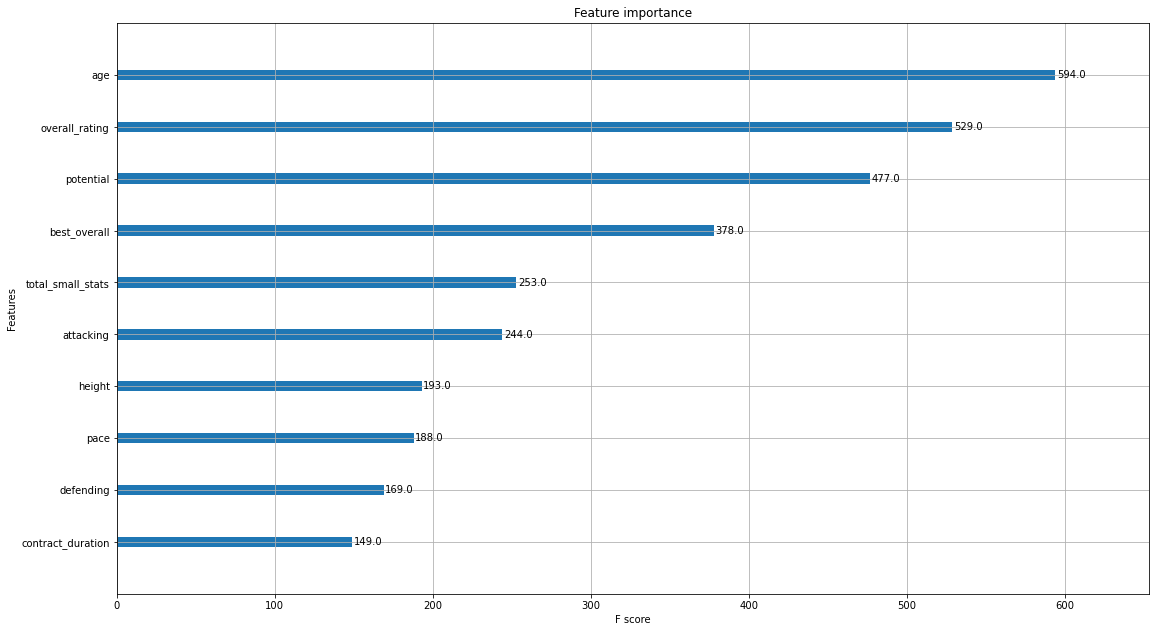

In [36]:
# Best model
params = xgb_bo.best_params_

xgb_best_model = xgb.XGBRegressor(random_state=42, **params)
xgb_best_model.fit(x_train, y_train)

fig = xgb.plot_importance(xgb_best_model, max_num_features = 10)
fig = fig.figure 
fig.set_size_inches(18.5, 10.5)